I want to integrate classical methods to optimize hyperparameters from quantum world.

In [1]:
# Install Qiskit Dynamics
!pip install qiskit-dynamics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.8 MB/s eta 0:00:00


In [16]:
import numpy as np
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.models import LindbladModel
from qiskit.quantum_info import Operator, Statevector, DensityMatrix, Pauli
import matplotlib.pyplot as plt


In [23]:
N = 6  # Number of qubits
omega_z = 2 * np.pi * 5e9  # Qubit frequency in rad/s (5 GHz)
omega_x = 2 * np.pi * 0.5e9  # Drive frequency in rad/s (0.5 GHz)
J = 2 * np.pi * 0.2e9  # Coupling strength in rad/s (0.2 GHz)
Gamma = 2 * np.pi * 1e6  # Dissipation rate in rad/s (1 MHz)
#initializing the operators X,Y, Z
x_ops = []
y_ops = []
z_ops = []
qubits = range(N)
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X = zeros + Pauli('X')(i)
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)

In [24]:
H = zeros
for i in qubits:
    X = x_ops[i]
    Z = z_ops[i]
    H += 0.5 * omega_x * X  # Driving term
    H += 0.5 * omega_z * Z  # Qubit energy term

    if N > 1:
        j = i + 1 if i < (N - 1) else 0
        op_xx = zeros + Pauli('XX')(i, j)
        op_yy = zeros + Pauli('YY')(i, j)
        H += 0.5 * J * (op_xx + op_yy)  # Interaction terms

In [25]:
# THE Lindblad operators (decay process)
L_ops = []
for i in qubits:
    X = x_ops[i]
    Y = y_ops[i]
    L_ops.append(np.sqrt(Gamma) * 0.5 * (X + 1j * Y))

In [26]:
solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

# all qubits in ground state
y0 = DensityMatrix.from_label('0' * N)

t_final = 2.0e-6  # Total simulation time (e.g., 2 microseconds)
tau = 0.01e-6  # Time step (10 ns)
n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

# Solve the Lindblad equation
sol = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)

In [27]:
# Calculate expectation values
n_times = len(sol.y)
x_data = np.zeros((N, n_times))
y_data = np.zeros((N, n_times))
z_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))
y_mean = np.zeros((n_times,))
z_mean = np.zeros((n_times,))

for t_i, sol_t in enumerate(sol.y):
    for qubit, obs in enumerate(x_ops):
        x_data[qubit, t_i] = sol_t.expectation_value(obs).real
    x_mean[t_i] = np.mean(x_data[:, t_i])

    for qubit, obs in enumerate(y_ops):
        y_data[qubit, t_i] = sol_t.expectation_value(obs).real
    y_mean[t_i] = np.mean(y_data[:, t_i])

    for qubit, obs in enumerate(z_ops):
        z_data[qubit, t_i] = sol_t.expectation_value(obs).real
    z_mean[t_i] = np.mean(z_data[:, t_i])

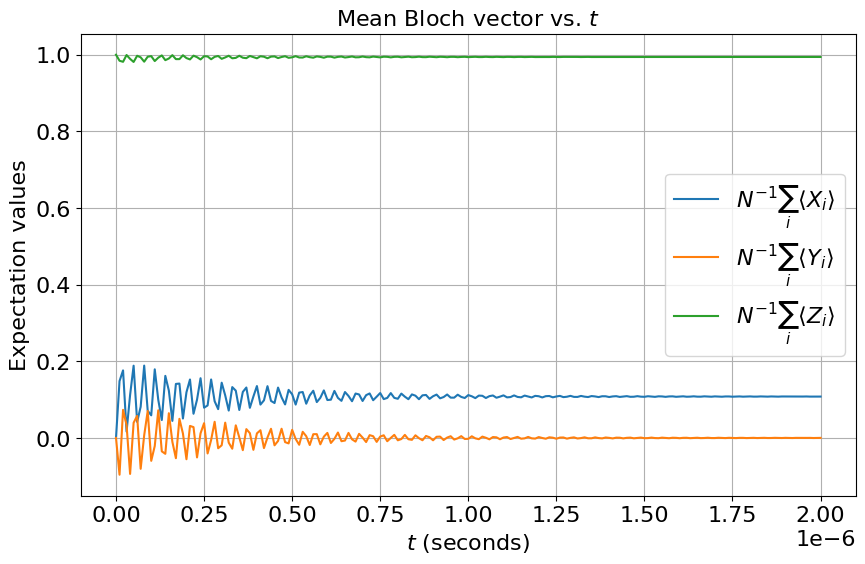

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval, x_mean, label='$ N^{-1}\\sum_i \\langle X_i \\rangle$')
plt.plot(t_eval, y_mean, label='$ N^{-1}\\sum_i \\langle Y_i \\rangle$')
plt.plot(t_eval, z_mean, label='$ N^{-1}\\sum_i \\langle Z_i \\rangle$')
plt.legend(fontsize=16)
plt.xlabel('$t$ (seconds)', fontsize=16)
plt.ylabel('Expectation values', fontsize=16)
plt.title('Mean Bloch vector vs. $t$', fontsize=16)
plt.grid(True)
plt.show()

OPTIMIZATION - CONCEPTUAL ALGORITHM

In [29]:
import numpy as np

class QuantumOptimizer:
    def __init__(self, objective_function, search_space, n_trials=100):
        """
        A basic optimizer for Quantum Machine Learning.

        Parameters:
        - objective_function: A callable function to minimize or maximize.
        - search_space: A dictionary defining parameter ranges, e.g., {'param1': (min, max)}.
        - n_trials: Number of optimization trials to run.
        """
        self.objective_function = objective_function
        self.search_space = search_space
        self.n_trials = n_trials
        self.best_params = None
        self.best_value = None

    def sample_parameters(self):
        """Randomly samples parameters from the search space."""
        return {key: np.random.uniform(low, high) for key, (low, high) in self.search_space.items()}

    def optimize(self):
        """Run the optimization loop."""
        for trial in range(self.n_trials):
            params = self.sample_parameters()
            value = self.objective_function(params)

            if self.best_value is None or value < self.best_value:
                self.best_value = value
                self.best_params = params

            print(f"Trial {trial+1}/{self.n_trials}: Value = {value}, Params = {params}")

        print(f"\nBest Value: {self.best_value}")
        print(f"Best Parameters: {self.best_params}")
        return self.best_params, self.best_value


In [30]:
from qiskit_dynamics import Solver
from qiskit.quantum_info import DensityMatrix

def lindblad_objective(params):
    """
    Objective function for optimizing Lindblad equation parameters.

    Parameters:
    - params: Dictionary containing parameters such as {'omega_x': value, 'omega_z': value, 'gamma': value}

    Returns:
    - A metric to minimize, e.g., the deviation from a target state or minimized energy.
    """
    omega_x = params['omega_x']
    omega_z = params['omega_z']
    J = params['J']
    Gamma = params['Gamma']

    # single qubit example
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    H = 0.5 * (omega_x * sigma_x + omega_z * sigma_z)
    L_ops = [np.sqrt(Gamma) * sigma_x]

    solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)

    y0 = DensityMatrix.from_label('0')

    t_final = 1e-6
    t_eval = np.linspace(0., t_final, 100)


    solution = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)


    final_state = solution.y[-1]
    target_state = DensityMatrix.from_label('0')
    fidelity = abs((final_state.data.conj().T @ target_state.data).trace())

    # Metric to minimize - INFIDELITY
    return 1 - fidelity


In [31]:
search_space = {
    'omega_x': (0, 2 * np.pi * 1e9),  # Range of omega_x (0 to 1 GHz)
    'omega_z': (0, 2 * np.pi * 1e9),  # Range of omega_z (0 to 1 GHz)
    'J': (0, 2 * np.pi * 0.5e9),      # Coupling strength (0 to 0.5 GHz)
    'Gamma': (0, 2 * np.pi * 5e6)     # Dissipation rate (0 to 5 MHz)
}

optimizer = QuantumOptimizer(objective_function=lindblad_objective, search_space=search_space, n_trials=20)

best_params, best_value = optimizer.optimize()


Trial 1/20: Value = 0.4999999439269466, Params = {'omega_x': 1753150639.7281978, 'omega_z': 4755638476.171682, 'J': 1131402911.5776303, 'Gamma': 29258131.485337514}
Trial 2/20: Value = 0.499999921850973, Params = {'omega_x': 3120930147.4125805, 'omega_z': 6114282813.843698, 'J': 1270397162.3362384, 'Gamma': 25369535.70487496}
Trial 3/20: Value = 0.4999997337281177, Params = {'omega_x': 2515150163.2333703, 'omega_z': 2982123088.494198, 'J': 1174261406.2610922, 'Gamma': 23331349.78084315}
Trial 4/20: Value = 0.49679936337370634, Params = {'omega_x': 6059733842.915726, 'omega_z': 1518751323.7498736, 'J': 715331869.919359, 'Gamma': 18796591.919982325}
Trial 5/20: Value = 0.5000001282357438, Params = {'omega_x': 6114380520.742224, 'omega_z': 3908713090.9119334, 'J': 202517622.89389434, 'Gamma': 30969115.490311082}
Trial 6/20: Value = 0.497803681417046, Params = {'omega_x': 5238538336.562709, 'omega_z': 397702050.29471606, 'J': 3113300214.47251, 'Gamma': 20143849.02078758}
Trial 7/20: Value 